In [52]:
import ai_land.model as model
#import ai_land.model_simple as model
import ai_land.data_module_cat as dm
import xarray
import numpy as np
import torch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
dev

'cuda:0'

In [53]:
dataset = dm.EcDataset()

In [56]:
input_clim_dim = dataset.x_static_scaled.shape[-1]
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
output_diag_dim = len(dataset.targ_diag_lst)
hidden_dim = 128  # 128  # 172  # 128  # 126
model_pyt = model.NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    output_diag_dim,
    dataset=dataset,
)

In [57]:
len(dataset)

15942

In [58]:
#model_pyt.load_state_dict(torch.load("model_126.pyt")["state_dict"])
#model_pyt.load_state_dict(torch.load("epoch=152-step=153765.ckpt")["state_dict"])
#model_pyt.load_state_dict(torch.load("epoch=48-step=195265.ckpt", map_location=torch.device(device))["state_dict"])
#model_pyt.load_state_dict(torch.load("epoch=61-step=247070.ckpt")["state_dict"])
model_pyt.load_state_dict(torch.load("epoch=2-step=11958.ckpt")["state_dict"])
model_pyt = model_pyt.to(device)

In [59]:
dataset = dm.EcDataset(
        start_yr=2018,
        end_yr=2022,
        path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6h.zarr",
        roll_out=1,
        x_idxs = (9973, 9974)
    )

print(f"Prognostic targets = {dataset.targ_lst}")
print(f"Diagnostic targets = {dataset.targ_diag_lst}")

Prognostic targets = ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc']
Diagnostic targets = ['d2m', 't2m', 'skt']


In [60]:
# Load data and put it onto device
clim_norm, met_norm, state_norm, state_diag_norm = [out_tensor.to(device) for out_tensor in dataset.load_data()]

In [61]:
%%time
with torch.no_grad():
    # run model
    preds_norm, preds_diag_norm = model_pyt.predict_step(clim_norm, met_norm, state_norm, state_diag_norm)
    
    # inverse "z" tranform targets and predictions
    preds = dataset.inv_transform(preds_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    preds = torch.clip(preds, 0, None)
    preds_diag = dataset.inv_transform(preds_diag_norm, dataset.y_diag_means.to(dev), dataset.y_diag_stdevs.to(dev))
    state = dataset.inv_transform(state_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    state_diag = dataset.inv_transform(state_diag_norm, dataset.y_diag_means.to(dev), dataset.y_diag_stdevs.to(dev))

CPU times: user 3.36 s, sys: 4.19 ms, total: 3.37 s
Wall time: 3.38 s


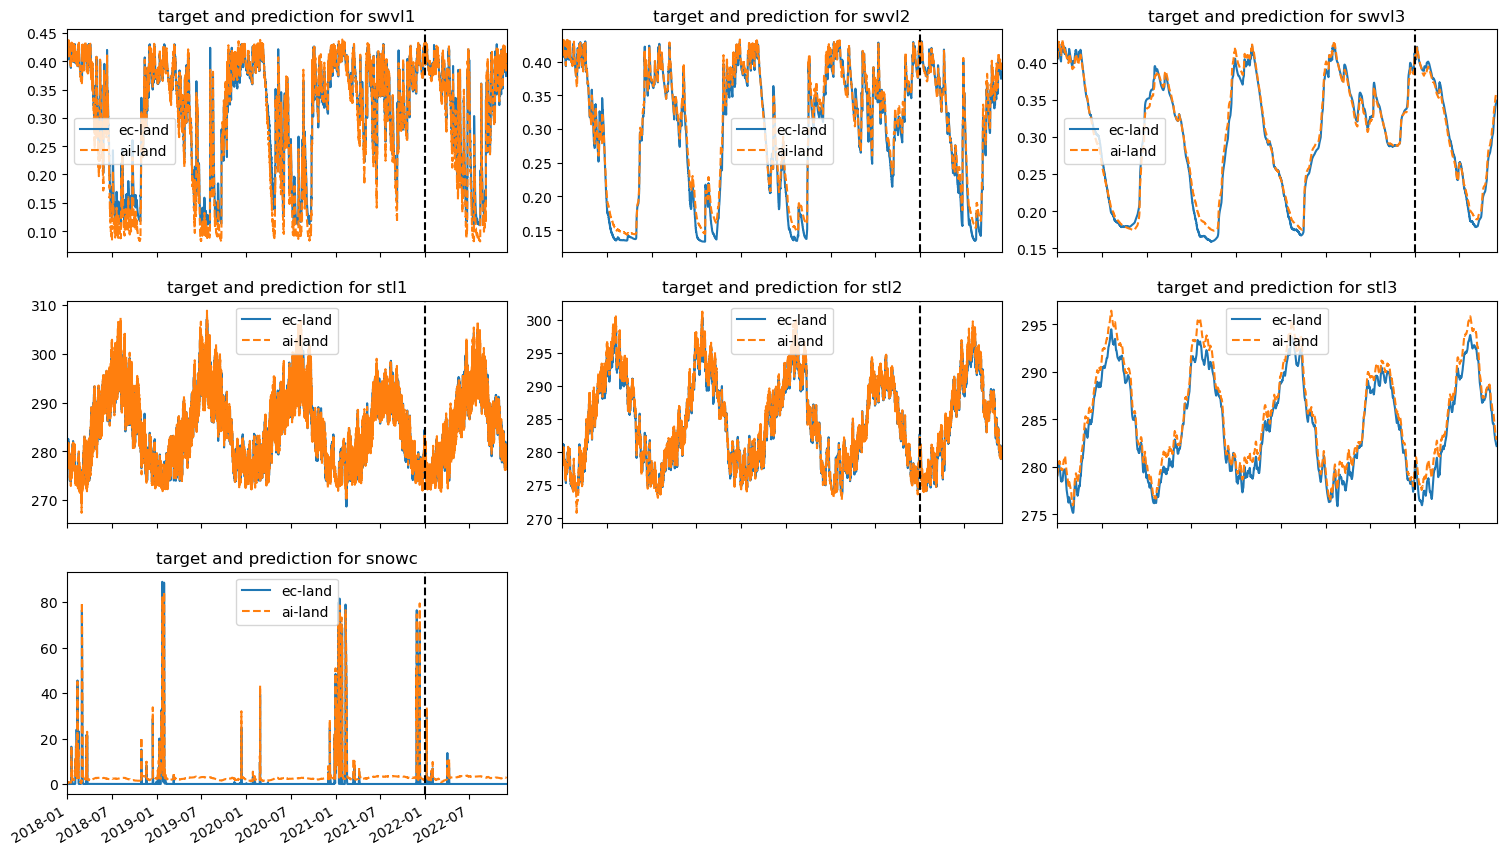

In [62]:
# Plot some timeseries validation for a specific gridcell
def plot_timeseries(times, targets, predictions, x_idx, state_idx, label, ax):
    ax.plot(dataset.times, state[:, x_idx, state_idx].cpu().numpy(), label="ec-land")
    ax.plot(dataset.times, preds[:, x_idx, state_idx].cpu().numpy(), '--', label="ai-land")
    ax.set_title(f"target and prediction for {label}")
    ax.set_xlim([times[0], times[-1]])
    ax.axvline(times[-334*4], color="k", linestyle="--")
    ax.legend()

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for i, var in enumerate(dataset.targ_lst):
    axes = ax.flatten()[i]
    plot_timeseries(dataset.times, state, preds, 0, i, var, axes)
    
ax.flatten()[-2].remove()
ax.flatten()[-1].remove()
fig.tight_layout()
fig.autofmt_xdate()

In [63]:
dataset = dm.EcDataset(
        start_yr=2022,
        end_yr=2022,
        path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6h.zarr",
        roll_out=1,
    )

print(f"Prognostic targets = {dataset.targ_lst}")
print(f"Diagnostic targets = {dataset.targ_diag_lst}")

clim_norm, met_norm, state_norm, state_diag_norm = [out_tensor.to(device) for out_tensor in dataset.load_data()]

with torch.no_grad():
    # run model
    preds_norm, preds_diag_norm = model_pyt.predict_step(clim_norm, met_norm, state_norm, state_diag_norm)
    
    # inverse "z" tranform targets and predictions
    preds = dataset.inv_transform(preds_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    preds = torch.clip(preds, 0, None)
    preds_diag = dataset.inv_transform(preds_diag_norm, dataset.y_diag_means.to(dev), dataset.y_diag_stdevs.to(dev))
    state = dataset.inv_transform(state_norm, dataset.y_prog_means.to(dev), dataset.y_prog_stdevs.to(dev))
    state_diag = dataset.inv_transform(state_diag_norm, dataset.y_diag_means.to(dev), dataset.y_diag_stdevs.to(dev))

Prognostic targets = ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc']
Diagnostic targets = ['d2m', 't2m', 'skt']


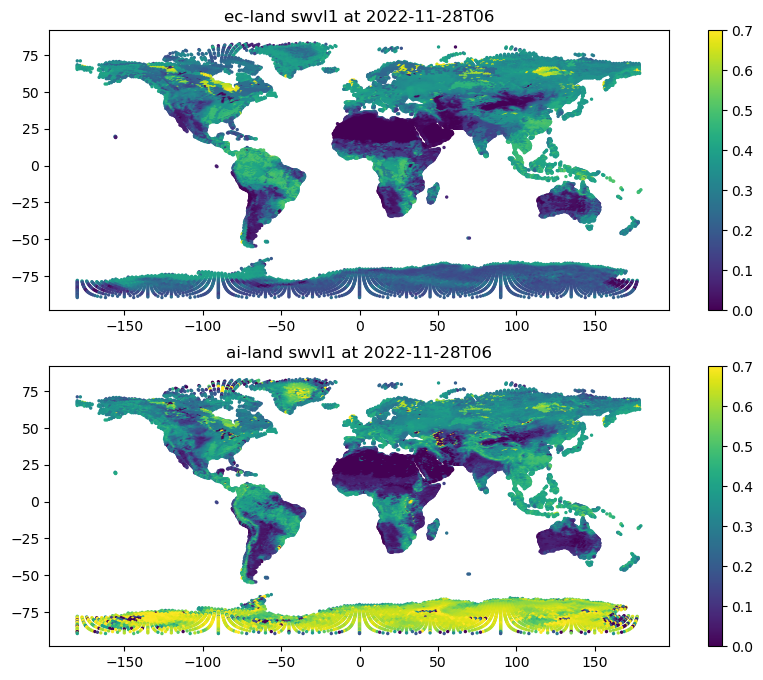

In [64]:
state_idx = 0
t_idx = -10

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.7, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=0.7, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

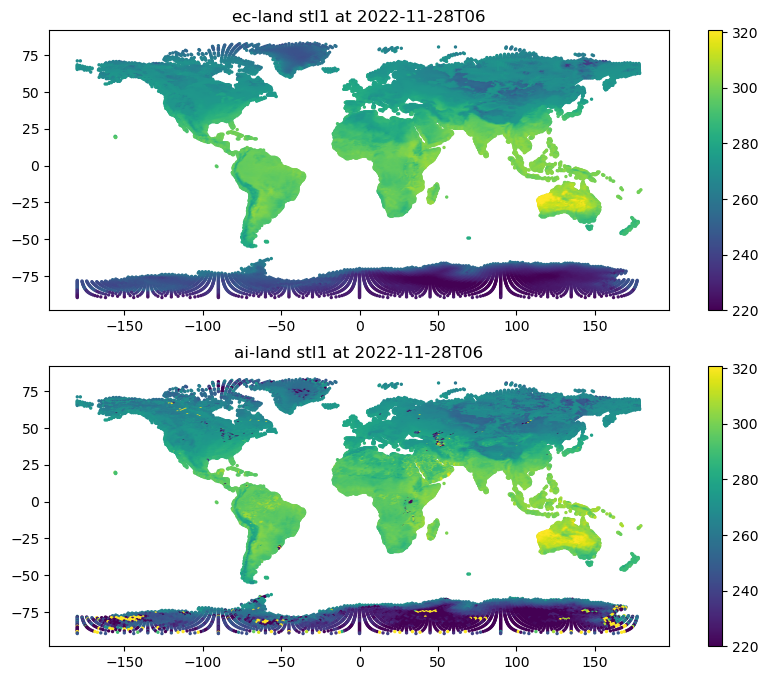

In [65]:
state_idx = 3
t_idx = -10

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=220, vmax=320.7, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=220, vmax=320.7, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

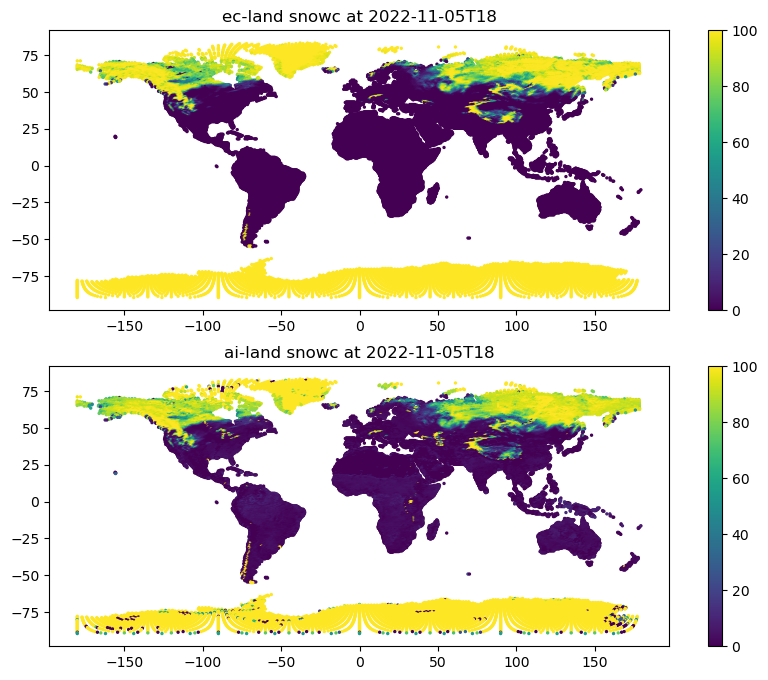

In [66]:
state_idx = 6
t_idx = -100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

c1 = ax[0].scatter(dataset.lons, dataset.lats, c=state[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=100, s=2)
ax[0].set_title(f"ec-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
c2 = ax[1].scatter(dataset.lons, dataset.lats, c=preds[t_idx, :, state_idx].cpu().numpy(), vmin=0, vmax=100, s=2)
ax[1].set_title(f"ai-land {dataset.targ_lst[state_idx]} at {str(dataset.times[t_idx])[:13]}")
plt.colorbar(c1)
plt.colorbar(c2)

In [49]:
import xarray as xr
da = xr.open_dataset("../../../ec-land-db/ec_land_db/scratch/surfclim_199_l4", engine="netcdf4", decode_times=False).compute()
da

<xarray.Dataset> Size: 14MB
Dimensions:    (x: 47892, month: 12)
Coordinates:
    lat        (x) float64 383kB 83.37 83.37 83.37 ... -89.66 -89.66 -89.66
    lon        (x) float64 383kB 322.1 326.8 331.6 283.5 ... 306.0 324.0 342.0
  * x          (x) int32 192kB 713 714 715 784 ... 167197 167198 167199 167200
  * month      (month) float32 48B 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Data variables: (12/24)
    cell_area  (x) float64 383kB 3.039e+09 3.039e+09 ... 5.899e+08 5.899e+08
    Malbedo    (month, x) float32 2MB 0.15 0.15 0.15 0.15 ... 0.15 0.15 0.15
    Mlail      (month, x) float32 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Mlaih      (month, x) float32 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fwet       (month, x) float32 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Mask       (x) int32 192kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ...         ...
    seaice     (x) float32 192kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LDEPTH     (x) float32 192kB 31.74 16.78 37.5 91.0 ... 10.0 10.0 10.0 10.0
    CLAKE      (x) float32 192kB 0.01227 0.003101 0.0003582 ... 0.0 0.0 0.0
    cu         (x) float32 192kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ctype      (x) float32 192kB 3.0 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    glm        (x) float32 192kB 0.4487 0.3394 0.2224 0.133 ... 1.0 1.0 1.0 1.0
Attributes:
    history:  Created Thu Dec 28 10:25:39 2023based onsurfclim_all

In [19]:
np.unique(da.geopot)

array([-3341.1667, -3270.1667, -3261.1667, ..., 54651.832 , 54652.832 ,
       54712.832 ], dtype=float32)

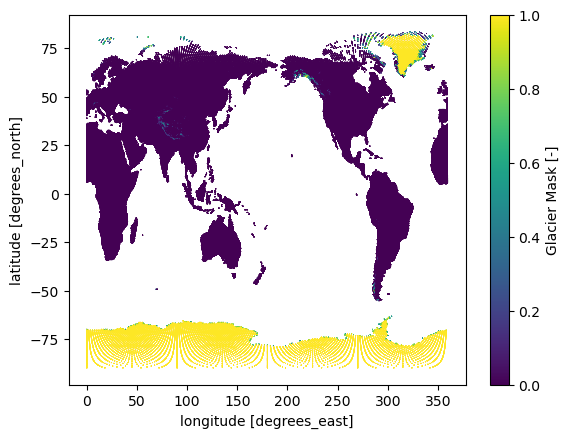

In [21]:
da.plot.scatter(x="lon", y="lat", hue="glm", edgecolor='none', s=0.5)

In [51]:
xr.open_zarr("/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h.zarr/")

<xarray.Dataset> Size: 463GB
Dimensions:                     (x: 187070, clim_variable: 23, time: 18744,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 184B 'clim_cell_area' ...
    lat                         (x) float32 748kB dask.array<chunksize=(187070,), meta=np.ndarray>
    lon                         (x) float32 748kB dask.array<chunksize=(187070,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 150kB 2010-02-01 ... 20...
  * variable                    (variable) object 264B 'met_ctpf' ... 'es'
  * x                           (x) int32 748kB 2192 2193 2194 ... 654399 654400
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 17MB dask.array<chunksize=(187070, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 463GB dask.array<chunksize=(4, 187070, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 25MB dask.array<chunksize=(187070, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 25MB dask.array<chunksize=(187070, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 25MB dask.array<chunksize=(23384, 9), meta=np.ndarray>
    global_data_means           (x, variable) float32 25MB dask.array<chunksize=(23384, 9), meta=np.ndarray>
    global_data_mins            (x, variable) float32 25MB dask.array<chunksize=(23384, 9), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 25MB dask.array<chunksize=(23384, 9), meta=np.ndarray>